# Bus-Stop

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df=pd.read_csv("features_embedded.csv")
df['norm_road']=df[['Signal', 'bus_stop', 'Turn','Congestion']].apply(lambda e: 1 if e[0]==e[1]==e[2]==e[3]==0 else 0,axis=1)

In [3]:
labels=df[['norm_road','Signal', 'Turn','bus_stop','Congestion']].values
features=df.drop(columns=['norm_road','Signal', 'bus_stop', 'Turn','Congestion'])

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
s=MinMaxScaler()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

In [6]:
X_train=s.fit_transform(X_train)
X_test=s.transform(X_test)

# Modelling

In [14]:
import tensorflow as tf

In [15]:
print(y_train.dtype)

int64


In [16]:
#<pre>
dataset=tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(1000).repeat(-1).batch(32)
next_batch=dataset.make_one_shot_iterator().get_next()
#</pre>

In [17]:
def Neural_Net(X,hidden,dropout,mode):
    
    net=tf.contrib.layers.fully_connected(X,hidden,tf.nn.relu)
    #net=tf.contrib.layers.dropout(net,keep_prob=1-dropout,is_training=mode)
    #net=tf.contrib.layers.batch_norm(net,is_training=mode)
    
    net=tf.contrib.layers.fully_connected(net,hidden,tf.nn.relu)
    #net=tf.contrib.layers.dropout(net,keep_prob=1-dropout,is_training=mode)
    #net=tf.contrib.layers.batch_norm(net,is_training=mode)

    net=tf.contrib.layers.fully_connected(net,hidden,tf.nn.relu)
    #net=tf.contrib.layers.dropout(net,keep_prob=1-dropout,is_training=mode)
    #net=tf.contrib.layers.batch_norm(net,is_training=mode)
    
    net=tf.contrib.layers.fully_connected(net,hidden,tf.nn.relu)
    #net=tf.contrib.layers.dropout(net,keep_prob=1-dropout,is_training=mode)
    #net=tf.contrib.layers.batch_norm(net,is_training=mode)

    logits=tf.contrib.layers.fully_connected(net,5,None)
    y_pred_class=tf.round(tf.nn.sigmoid(logits))
    return logits,y_pred_class



X=tf.placeholder(tf.float32,[None,17])
Y=tf.placeholder(tf.float32,[None,5])
mode=tf.placeholder(tf.bool)

logits,y_pred_class=Neural_Net(X,128,0.5,mode)

accuracy=tf.reduce_mean(tf.cast(tf.equal(y_pred_class,Y),tf.float32))
loss=tf.nn.sigmoid_cross_entropy_with_logits(labels=Y,logits=logits)+\
     (0.01/64)*tf.reduce_sum(list(map(tf.reduce_sum,map(tf.square,tf.trainable_variables()))))
optimizer=tf.train.AdamOptimizer().minimize(loss)

W0401 20:43:21.883664 140572603721536 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0401 20:43:21.886309 140572603721536 deprecation.py:323] From /home/abhijit/.local/lib/python3.6/site-packages/tensorflow_core/contrib/layers/python/layers/layers.py:1866: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
W0401 20:43:22.191079 140572603721536 deprecation.py:323] From /home/abhijit/.local/lib/python3.6/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and 

In [11]:
sess=tf.Session()
init=tf.global_variables_initializer()
sess.run(init)

In [12]:
saver=tf.train.Saver()
#saver.save(sess,"./saved_models/my_model.ckpt")
saver.restore(sess,"./saved_models/my_model.ckpt")

In [1]:
#<pre>
steps=1*50000

for step in range(steps):
    bx,by=sess.run(next_batch)
    sess.run(optimizer,feed_dict={X:bx,Y:by,mode:True})
    if step%100==0:
        acc=sess.run(accuracy,feed_dict={X:bx,Y:by,mode:False})
        print("ON STEP {} ACC {}".format(step,acc))
        #if acc>0.7650:
        #    break
#</pre>

NameError: name 'sess' is not defined

# Testing

In [13]:
print("Overall acc:",sess.run(accuracy,feed_dict={X:X_test,Y:y_test,mode:False}))
pred=sess.run(y_pred_class,feed_dict={X:X_test,mode:False})

print("Normal Road acc:",(pred[:,0]==y_test[:,0]).mean())

print("Signal acc:",(pred[:,1]==y_test[:,1]).mean())

print("Turn acc:",(pred[:,2]==y_test[:,2]).mean())

print("Bus stop acc:",(pred[:,3]==y_test[:,3]).mean())

print("Congestion acc:",(pred[:,4]==y_test[:,4]).mean())

Overall acc: 0.84604317
Normal Road acc: 0.7859712230215827
Signal acc: 0.8687050359712231
Turn acc: 0.8794964028776978
Bus stop acc: 0.8093525179856115
Congestion acc: 0.8866906474820144


# Training

In [14]:
print("Overall acc:",sess.run(accuracy,feed_dict={X:X_train,Y:y_train,mode:False}))

pred=sess.run(y_pred_class,feed_dict={X:X_train,mode:False})

print("Normal Road acc:",(pred[:,0]==y_train[:,0]).mean())

print("Signal acc:",(pred[:,1]==y_train[:,1]).mean())

print("Turn acc:",(pred[:,2]==y_train[:,2]).mean())

print("Bus stop acc:",(pred[:,3]==y_train[:,3]).mean())

print("Congestion acc:",(pred[:,4]==y_train[:,4]).mean())

Overall acc: 0.97815275
Normal Road acc: 0.9689165186500888
Signal acc: 0.9751332149200711
Turn acc: 0.9849023090586145
Bus stop acc: 0.9813499111900533
Congestion acc: 0.9804618117229129


# Analytics

In [15]:
from sklearn.metrics import classification_report,confusion_matrix

In [16]:
pred=sess.run(y_pred_class,feed_dict={X:X_test,mode:False})
print("classification report Norm:\n",classification_report(y_test[:,0],pred[:,0]))
print("classification report Signal:\n",classification_report(y_test[:,1],pred[:,1]))
print("classification report Turn:\n",classification_report(y_test[:,2],pred[:,2]))
print("classification report Bus-Stop\n:",classification_report(y_test[:,3],pred[:,3]))
print("classification report Congestion\n:",classification_report(y_test[:,4],pred[:,4]))

classification report Norm:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84       383
           1       0.64      0.71      0.67       173

    accuracy                           0.79       556
   macro avg       0.75      0.77      0.76       556
weighted avg       0.79      0.79      0.79       556

classification report Signal:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       442
           1       0.68      0.67      0.68       114

    accuracy                           0.87       556
   macro avg       0.80      0.79      0.80       556
weighted avg       0.87      0.87      0.87       556

classification report Turn:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93       466
           1       0.64      0.58      0.61        90

    accuracy                           0.88       556
   macro avg       0.78      0.76      

confusion_matrix Norm:



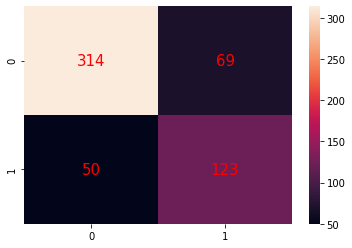

confusion_matrix Signal:



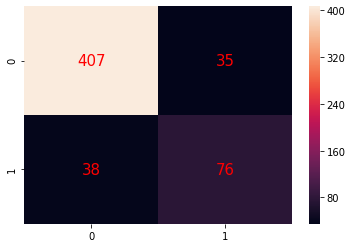

confusion_matrix Turn:



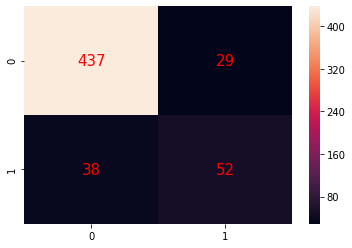

confusion_matrix Bus-Stop
:


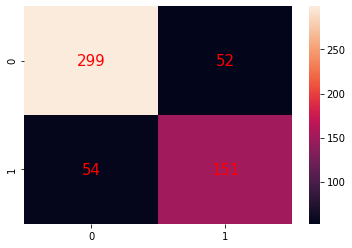

confusion_matrix Congestion
:


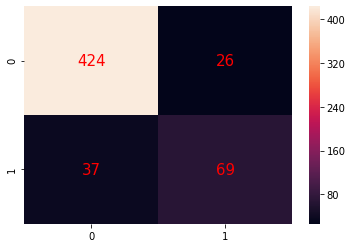

In [17]:
pred=sess.run(y_pred_class,feed_dict={X:X_test,mode:False})
print("confusion_matrix Norm:\n")
_=sns.heatmap(confusion_matrix(y_test[:,0],pred[:,0]),annot=True,fmt='d',annot_kws={"size":15,'color':'r'})
plt.show()
print("confusion_matrix Signal:\n")
_=sns.heatmap(confusion_matrix(y_test[:,1],pred[:,1]),annot=True,fmt='d',annot_kws={"size":15,'color':'r'})
plt.show()
print("confusion_matrix Turn:\n")
_=sns.heatmap(confusion_matrix(y_test[:,2],pred[:,2]),annot=True,fmt='d',annot_kws={"size":15,'color':'r'})
plt.show()
print("confusion_matrix Bus-Stop\n:")
_=sns.heatmap(confusion_matrix(y_test[:,3],pred[:,3]),annot=True,fmt='d',annot_kws={"size":15,'color':'r'})
plt.show()
print("confusion_matrix Congestion\n:")
_=sns.heatmap(confusion_matrix(y_test[:,4],pred[:,4]),annot=True,fmt='d',annot_kws={"size":15,'color':'r'})
plt.show()

In [18]:
#NICE

# Temporal plots

In [19]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [20]:
df.columns

Index(['next_stop_distance', 'total_waiting_time', 'wifi_count', 'honks',
       'rsi', 'Signal', 'bus_stop', 'Turn', 'zone_highway',
       'zone_market_place', 'zone_normal_city', 'time_level_1', 'time_level_2',
       'time_level_3', 'time_level_4', 'Population_density_dense',
       'Population_density_medium', 'Population_density_sparse',
       'Weekend/day_Week-day', 'Weekend/day_Week-end', 'Congestion',
       'norm_road'],
      dtype='object')

# predicting on test_data

In [21]:
new_df=pd.DataFrame(np.concatenate([X_test,y_test],axis=1),columns=list(features.columns)+['norm_road','Signal', 'Turn','bus_stop','Congestion'])

In [29]:
new_df.shape

(556, 22)

In [22]:
def Analyse(column,new_df,need_scaling=False):
    
    test_df=new_df[new_df[column]==1]
    
    feat=test_df.drop(columns=['norm_road','Signal', 'Turn','bus_stop','Congestion']).values
    if need_scaling:feat=s.transform(feat)
        
    y_tr=test_df[['norm_road','Signal', 'Turn','bus_stop','Congestion']].values

    feed_dict={X:feat,
               Y:y_tr}

    pred=sess.run(y_pred_class,feed_dict=feed_dict)
    
    return\
    {'Norm':{'accuracy':accuracy_score(y_tr[:,0],pred[:,0]),'precision':precision_score(y_tr[:,0],pred[:,0]),'recall':recall_score(y_tr[:,0],pred[:,0]),'f1_score':f1_score(y_tr[:,0],pred[:,0])},
     'Signal':{'accuracy':accuracy_score(y_tr[:,1],pred[:,1]),'precision':precision_score(y_tr[:,1],pred[:,1]),'recall':recall_score(y_tr[:,1],pred[:,1]),'f1_score':f1_score(y_tr[:,1],pred[:,1])},
     'Turn':{'accuracy':accuracy_score(y_tr[:,2],pred[:,2]),'precision':precision_score(y_tr[:,2],pred[:,2]),'recall':recall_score(y_tr[:,2],pred[:,2]),'f1_score':f1_score(y_tr[:,2],pred[:,2])},
     'Bus_stop':{'accuracy':accuracy_score(y_tr[:,3],pred[:,3]),'precision':precision_score(y_tr[:,3],pred[:,3]),'recall':recall_score(y_tr[:,3],pred[:,3]),'f1_score':f1_score(y_tr[:,3],pred[:,3])},
     'Congestion':{'accuracy':accuracy_score(y_tr[:,4],pred[:,4]),'precision':precision_score(y_tr[:,4],pred[:,4]),'recall':recall_score(y_tr[:,4],pred[:,4]),'f1_score':f1_score(y_tr[:,4],pred[:,4])}}
    
    

In [23]:
def plot_res(res,column):
    fig=plt.figure(figsize=(10,3))

    ax1=fig.add_subplot(151)
    ax1.set_xlabel('Norm')
    ax1.bar(res['Norm'].keys(),res['Norm'].values(),color=sns.color_palette())
    ax1.tick_params(axis='x', labelrotation=45)
    ax1.set_ylim(0,1)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')


    ax2=fig.add_subplot(152)
    ax2.set_xlabel('Signal')
    ax2.bar(res['Signal'].keys(),res['Signal'].values(),color=sns.color_palette())
    ax2.tick_params(axis='x', labelrotation=45)
    ax2.set_ylim(0,1)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.set_yticks([])
    ax2.xaxis.set_ticks_position('bottom')



    ax3=fig.add_subplot(153)
    ax3.set_xlabel('Turn')
    ax3.bar(res['Turn'].keys(),res['Turn'].values(),color=sns.color_palette())
    ax3.tick_params(axis='x', labelrotation=45)
    ax3.set_ylim(0,1)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.set_yticks([])
    ax3.xaxis.set_ticks_position('bottom')



    ax4=fig.add_subplot(154)
    ax4.set_xlabel('Bus_stop')
    ax4.bar(res['Bus_stop'].keys(),res['Bus_stop'].values(),color=sns.color_palette())
    ax4.tick_params(axis='x', labelrotation=45)
    ax4.set_ylim(0,1)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    ax4.set_yticks([])
    ax4.xaxis.set_ticks_position('bottom')



    ax5=fig.add_subplot(155)
    ax5.set_xlabel('Congestion')
    ax5.bar(res['Congestion'].keys(),res['Congestion'].values(),color=sns.color_palette())
    ax5.tick_params(axis='x', labelrotation=45)
    ax5.set_ylim(0,1)
    ax5.spines['right'].set_visible(False)
    ax5.spines['top'].set_visible(False)
    ax5.spines['left'].set_visible(False)
    ax5.set_yticks([])
    ax5.xaxis.set_ticks_position('bottom')

    fig.suptitle(column,fontsize=16)
    fig.savefig('./picture/'+column.split('/')[-1]+'.png')
    plt.show()

# plots on time_level

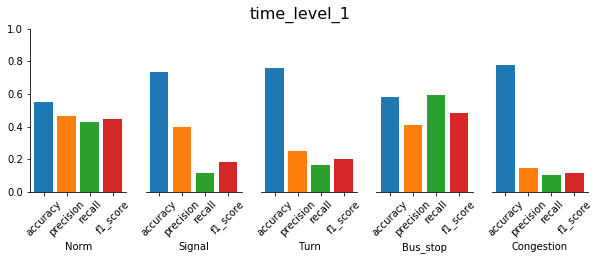

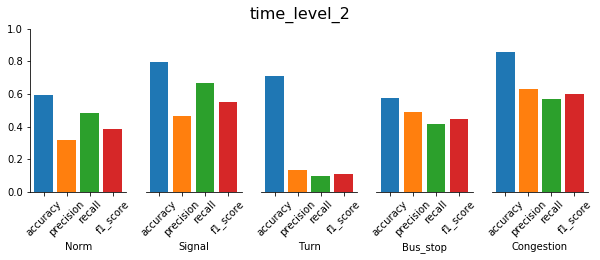

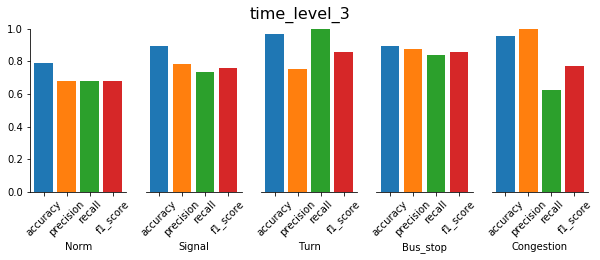

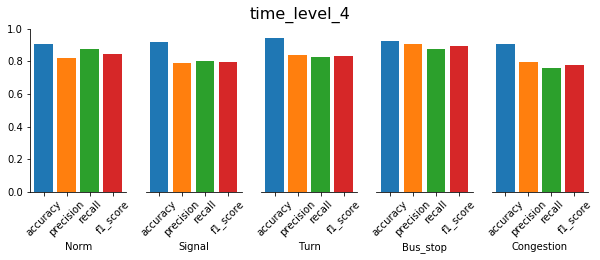

In [24]:
res=Analyse('time_level_1',new_df)
plot_res(res,'time_level_1')

res=Analyse('time_level_2',new_df)
plot_res(res,'time_level_2')

res=Analyse('time_level_3',new_df)
plot_res(res,'time_level_3')

res=Analyse('time_level_4',new_df)
plot_res(res,'time_level_4')

# plots on zone

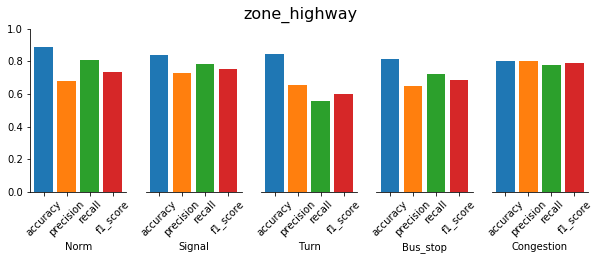

/home/abhijit/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/abhijit/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/abhijit/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/abhijit/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/abhijit/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: Unde

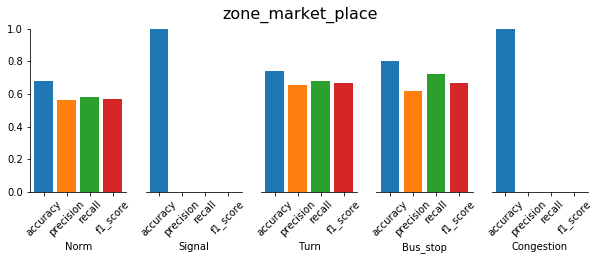

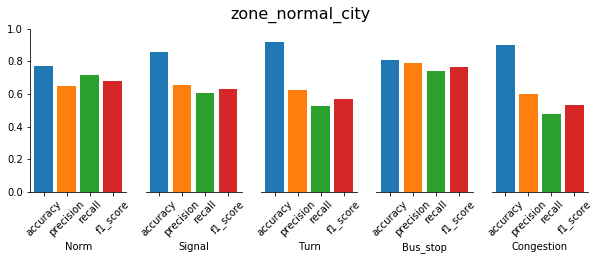

In [25]:
res=Analyse('zone_highway',new_df)
plot_res(res,'zone_highway')

res=Analyse('zone_market_place',new_df)
plot_res(res,'zone_market_place')

res=Analyse('zone_normal_city',new_df)
plot_res(res,'zone_normal_city')

# plots on population

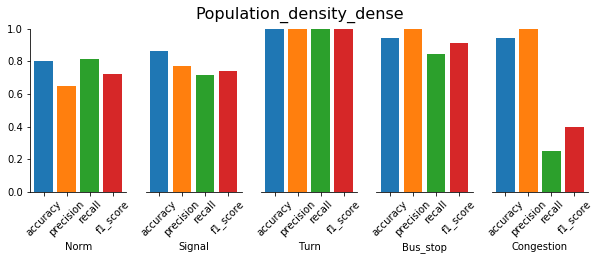

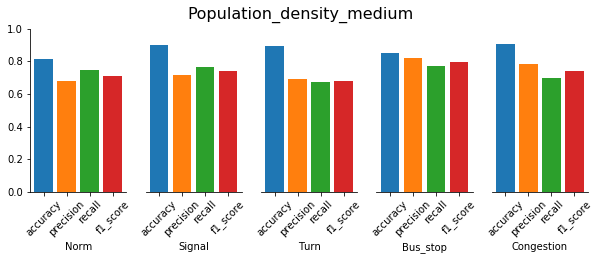

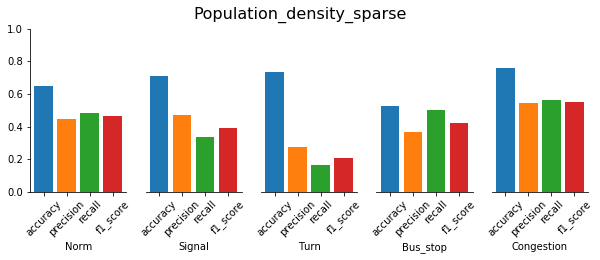

In [26]:
res=Analyse('Population_density_dense',new_df)
plot_res(res,'Population_density_dense')

res=Analyse('Population_density_medium',new_df)
plot_res(res,'Population_density_medium')

res=Analyse('Population_density_sparse',new_df)
plot_res(res,'Population_density_sparse')

# plots on week-day

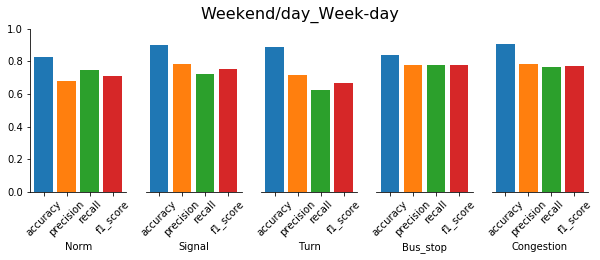

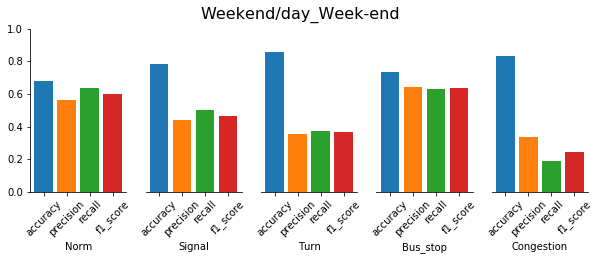

In [27]:
res=Analyse('Weekend/day_Week-day',new_df)
plot_res(res,'Weekend/day_Week-day')

res=Analyse('Weekend/day_Week-end',new_df)
plot_res(res,'Weekend/day_Week-end')

In [28]:
#DONE